# Pairwise Binary classification with Deep Learning

In this notebook we will train Multilayer Perceptron Neural Network to detect whether two images are from same class (car brand) or not. To train Perceptron, we will use image embeddings got from trained CNN model (SOTA models such as MobileNet).

# 1. Set up

## 1. Packages and requirements

In [1]:
# Major builtin libraries
import os
import gc
# import cv2
# import math
import time
import random
import typing as t
from copy import deepcopy
# from collections import defaultdict

In [2]:
# To work with Google Collab
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [3]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [5]:
# Basic PyTorch
import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms and dynamic learning rate adjusting
import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss  # For writing a custom Loss function
from torch.utils.data import DataLoader, Dataset  # For custom data presentation

In [6]:
# Utils
import joblib  # Pipelining, pickling (dump/load), parallel processing
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold  # Cross-Validation

In [7]:
# !pip install torchmetrics colorama

In [8]:
# ML Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchmetrics.classification import MulticlassF1Score # F1 metric for multiclass

In [9]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
from torchvision import models  # Pretrained models

In [10]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [11]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

In [12]:
import wandb # MLOps platform to simplify and speed up the process of building ML models

In [13]:
wandb.login() # We log in via pop-up,
# wandb.login(key=api_key)  # but you can also log in manually with function args

wandb: Currently logged in as: remainedmind. Use `wandb login --relogin` to force relogin


True

## 2. Configuration

In [14]:
CONFIG = {
    "seed": 2306,
    # "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "SiamesePerceptron",  # Pretrained model we will use
    "embedding_size": 512,  # Embedding output size
    "train_batch_size": 200,
    "val_batch_size": 400,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-7, # To stop training on plateau
    "weight_decay": 1e-7,

}

In [15]:
wandb_run = wandb.init(project="binary-classification-project", config=CONFIG)

In [16]:
config = wandb.config
del CONFIG

Set Seed for Reproducibility

In [17]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False  # When False, this option makes CUDA reproducible, BUT the performance might suffer

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed=config.seed)

# 2. Data

For our MLP we will use image embeddings - output from CNN models. We already got this data before, so we just load it.

## 1. Set data location

In [18]:
# config.repo = 'car-brands/'  # dataset name on Kaggle
config.repo = 'data/'  # dataset name on local device
# config.repo = 'car_brand_detection/'  # Google Collab

# config.root = '/kaggle/input/' + config.repo
# config.root = 'drive/MyDrive/' + config.repo
config.root = '../'  + config.repo


config.data = config.root

# config.train_images_path  = config.data + 'images/train'
# config.test_images_path = config.data + 'images/test'
# config.train_labels  = config.data + 'train_labels.csv'
# config.test_labels = config.data + 'test_labels.csv'
# config.embedding_model_path = '/kaggle/input/efficient-model/ArcFace_mobilenet_v2.pth'


config.data_path = config.data + 'embeddings_and_labels.csv'


config.save_model_to = f'{config.model_name}.pth'

In [32]:
df = pd.read_csv(config.data_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,...,0.410457,-0.024682,0.178265,-0.357340,-0.073279,0.190458,-0.060786,0.364546,0.824516,Acura_MDX
1,0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.428920,-0.016147,...,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426,Acura_MDX
2,-0.203165,0.330612,-0.413488,-0.128357,0.013811,0.244605,-0.137738,0.365148,0.385303,0.318809,...,0.413026,0.040102,0.054195,-0.251548,-0.020557,0.241178,0.062900,0.354683,0.591870,Acura_MDX
3,-0.052456,0.385235,-0.423291,-0.007358,0.031012,0.242327,0.118072,0.235620,0.464901,0.320997,...,0.412529,0.015200,0.237078,-0.429586,-0.110773,0.166453,0.079581,0.243743,0.662615,Acura_MDX
4,0.092909,0.075529,-0.040490,0.137453,0.531280,0.219033,-0.100117,0.161784,-0.077920,-0.265161,...,-0.024520,0.143381,-0.099898,0.137324,0.137523,0.217806,0.313156,0.400654,0.217053,Acura_MDX


In [33]:
df.columns[-20:]

Index(['493', '494', '495', '496', '497', '498', '499', '500', '501', '502',
       '503', '504', '505', '506', '507', '508', '509', '510', '511', 'label'],
      dtype='object')

**Label** is our last columns. Rest are embeddings

In [35]:
embeddings_bag = df[(df.columns[:-1])]
embeddings_bag.head(2)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,...,0.111356,0.410457,-0.024682,0.178265,-0.357340,-0.073279,0.190458,-0.060786,0.364546,0.824516
1,0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.428920,-0.016147,...,0.135340,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426


In [72]:
labels = df[df.columns[-1]]
labels.head(2)

0    Acura_MDX
1    Acura_MDX
Name: label, dtype: object

In [73]:
labels.unique()

array(['Acura_MDX', 'Alfa Romeo_Giulietta', 'Audi_100', 'Audi_80',
       'Audi_A1', 'Audi_A3', 'Audi_A4', 'Audi_A5', 'Audi_A6', 'Audi_A7',
       'Audi_A8', 'Audi_Q3', 'Audi_Q5', 'Audi_Q7', 'Audi_R8', 'Audi_RS6',
       'Audi_S5', 'Audi_S8', 'Audi_TT', 'BAW_FENIX', 'BAZ_A079_ETALON',
       'BMW_1_Series', 'BMW_3_Series', 'BMW_4_Series', 'BMW_5_Series',
       'BMW_6_Series', 'BMW_7_Series', 'BMW_X1', 'BMW_X3', 'BMW_X4',
       'BMW_X5', 'BMW_X6', 'BMW_Z3', 'BMW_Z4', 'BRILLIANCE_V5',
       'CARRUS_STAR', 'BYD_F3', 'Cadillac_CTS', 'Cadillac_Escalade',
       'Cadillac_SRX', 'CHERY_AMULET_A15', 'CHERY_FORA', 'CHERY_KIMO_S12',
       'CHERY_TIGGO', 'CHERY_TIGGO_5', 'CHERY_TIGGO_T11',
       'Chevrolet_Aveo', 'Chevrolet_Blazer', 'Chevrolet_Camaro',
       'Chevrolet_CAPRICE', 'Chevrolet_Captiva', 'Chevrolet_Cobalt',
       'Chevrolet_Cruze', 'Chevrolet_Epica', 'Chevrolet_Express',
       'Chevrolet_LACETTI', 'Chevrolet_LANOS', 'Chevrolet_NIVA',
       'Chevrolet_Orlando', 'Chevrolet_REZZ

Now we apply One Hot Encoding

In [74]:
def apply_label_encoding(labels: t.Union[pd.Series, np.array],
                         encoder_name: os.path,
                         action='encode',
     ):
    """
    One Hot encoding. We apply encoding by replacing the label column in dataframe.
    As for decoding data back, we work with vector-array (as it's most likely to
    be a prediction result)
    """
    encoder = LabelEncoder()
    if action == 'encode':
        # We transform dataframe here. Nothing returns
        # data = data.with_columns(pl.DataFrame(encoder.fit_transform(data[column]), schema=['label']))
        labels = encoder.fit_transform(labels)

        with open(f"{encoder_name}_LEncoder.pkl", "wb") as fp:
                joblib.dump(encoder, fp)
        return labels
    elif action == 'decode':
        # We pass vector here. Result is a vector
        with open(f"{encoder_name}_LEncoder.pkl", "rb") as fp:
            encoder: LabelEncoder = joblib.load(fp)
        return encoder.inverse_transform(labels)

In [75]:
labels = pd.DataFrame(apply_label_encoding(labels, action='encode', encoder_name="embeddings_labels"), columns=['label'])
labels.head()

,label
0,0
1,0
2,0
3,0
4,0


In [76]:
apply_label_encoding(labels, action='decode', encoder_name="embeddings_labels")

array(['Acura_MDX', 'Acura_MDX', 'Acura_MDX', ..., 'ZIL_5301_Bychok',
       'ZIL_5301_Bychok', 'ZIL_5301_Bychok'], dtype=object)

## Pytorch Dataset to run model on

In [77]:
class SiameseDataset(Dataset):
    def __init__(self, embeddings_data, labels):
        super().__init__()

        self.labels = labels
        self.embeddings_data = embeddings_data
        self.__set_dataset_len()
        self.similarity_flag = True


    def __set_dataset_len(self):
        a = self.labels.shape[0] # Number of rows
        b = self.embeddings_data.shape[0] # Amount of images
        assert a == b  # CSV content and real number of photos are equal
        self.length = a


    def __len__(self):
        """
        We calculate the len in another function, so that we are able to set it manually.
        """
        return self.length


    def __get_random_embedding(self, indexes):
        image_index = np.random.choice(indexes)
        embegging, label = self.embeddings_data[image_index], self.labels[image_index]
        return embegging, label


    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """
        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            self.embeddings_data = self.embeddings_data[:self.length]
            return self


        anchor, anchor_label = self.embeddings_data[index], self.labels[index]
        positive_or_negative = np.where(
            ((self.labels == anchor_label) == self.similarity_flag)
        )[0]

        # Delete source index, so we don't take two same pictures
        correct_indexes = np.delete(positive_or_negative, np.where(positive_or_negative == index))

        if len(correct_indexes) < 1:
            self.similarity_flag = not self.similarity_flag
            return self[index]

        p_or_n_embedding, second_label = self.__get_random_embedding(correct_indexes)

        self.similarity_flag = not self.similarity_flag  # Switch the flag

        return anchor, p_or_n_embedding, float(anchor_label==second_label)


In [78]:
from sklearn.model_selection import train_test_split

In [87]:
train_embeddings_bag, test_embeddings_bag, train_labels, test_labels = train_test_split(embeddings_bag, labels, random_state=config.seed, test_size=0.05)

In [88]:
train_labels.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
test_embeddings_bag.reset_index(drop=True, inplace=True)
train_embeddings_bag.reset_index(drop=True, inplace=True)


In [89]:
train_dataset = SiameseDataset(embeddings_data=train_embeddings_bag, labels=train_labels)
test_dataset = SiameseDataset(embeddings_data=test_embeddings_bag, labels=test_labels)

In [94]:
test_embeddings_bag.[10]

KeyError: 10

In [90]:
test_dataset[10]

KeyError: 10

In [68]:
train_embeddings_bag

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
4887,0.037575,-0.066096,-0.016135,-0.062686,-0.194813,0.190746,-0.417798,-0.185237,-0.291453,-0.473893,...,-0.210712,0.293591,0.085848,-0.078687,-0.272077,0.054797,-0.338254,-0.191663,-0.011458,-0.056422
9556,-0.041652,0.438315,0.013559,-0.046987,0.021649,-0.110765,-0.261692,-0.487588,-0.052194,0.024853,...,0.310035,0.132173,-0.093009,-0.087218,0.101687,0.260449,-0.245910,0.169747,0.083053,-0.367968
16403,-0.078765,-0.226591,0.034742,0.080701,-0.079768,0.096030,-0.055759,0.091666,-0.267085,0.214377,...,-0.106504,-0.020903,-0.325432,0.005511,0.008779,0.175032,-0.142119,0.040374,-0.029455,0.125380
12059,-0.639670,0.034599,-0.167871,0.357551,0.384221,-0.132520,-0.181177,-0.452871,0.339860,-0.044712,...,0.450946,-0.553067,-0.150648,0.208875,-0.167638,-0.119064,-0.086561,0.081693,0.209527,0.038392
16543,-0.432308,-0.091295,0.038741,-0.087281,-0.132383,0.316011,0.118130,-0.073155,-0.216728,0.427024,...,-0.092123,0.042614,0.015768,-0.262150,-0.072917,0.305093,-0.022806,0.113784,0.194165,0.484626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11088,-0.115002,-0.001155,0.359325,-0.316851,-0.328655,0.039792,-0.039318,-0.249942,0.780302,-0.140349,...,-0.004177,-0.109909,0.268295,0.181579,-0.042418,0.058142,0.514115,0.053900,-0.111740,0.377065
20074,0.183301,-0.181482,-0.150497,0.184815,0.214216,-0.022471,-0.022557,-0.023463,-0.072060,-0.462796,...,0.052693,-0.285461,-0.058376,-0.027986,0.026077,0.359280,-0.057999,-0.274840,-0.029227,0.032855
995,0.106969,0.134642,0.195039,-0.424222,-0.015339,-0.415955,-0.096164,-0.253265,0.195822,-0.097863,...,-0.244838,-0.171950,0.224962,0.098151,0.135813,0.332630,-0.220765,0.110880,-0.017790,-0.201594
13351,0.358733,-0.180579,-0.032065,-0.189290,0.131533,-0.334349,-0.276466,0.142602,0.127522,0.144114,...,0.193543,0.053381,-0.006492,-0.105606,-0.242649,0.066989,-0.071690,-0.101443,0.197346,-0.244758


# 3. Models

## Feedforward model to process embeddings pairs

In [96]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        square = (x1 - x2)**2
        # Pass the inputs through fully connected layers
        output = self.fc(square)
        return output

In [97]:
perceptron_model = SiameseNetwork(config.embedding_size)
perceptron_model

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1024, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

# 4. Various

## 1. Quality metrics

We will use accuracy and F1 score for out classification task

In [98]:
f1_score = MulticlassF1Score(num_classes=config.num_of_classes,)

## 2. Device

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
perceptron_model = perceptron_model.to(device)

f1_score = f1_score.to(device)
torch.cuda.empty_cache()

## 3. Data processing format

In [100]:
config.train_batch_size, config.val_batch_size = 160, 350

Split data to test and train for our Linear Model

In [63]:
torch.cuda.empty_cache()

In [64]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count() % 4,
)

In [65]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count() % 4,
                              )

## Choosing N nearest

In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')

In [68]:
neigh.fit(embeddings_bag.cpu().numpy())

NearestNeighbors(metric='cosine')

In [69]:
# found_nearest = neigh.kneighbors(torch.unsqueeze(r_embedding, dim=0).cpu().numpy())
found_nearest = neigh.kneighbors()

In [70]:
def get_dataset_with_nearest(array_of_nearest: np.array):
    neighbors = []
    for row_of_nearest in array_of_nearest:
#         print(row_of_nearest)

        labels_of_closest = []
        for nearest_label in row_of_nearest:
            labels_of_closest.append(labels[nearest_label].item())
#         print(labels_of_closest)
        neighbors.append(labels_of_closest)
    label_array = pd.DataFrame(neighbors)
    return label_array

neighbors_labels = get_dataset_with_nearest(found_nearest[1])

In [71]:
neighbors_labels.nunique()

0    760
1    760
2    760
3    760
4    758
dtype: int64

In [72]:
# neighbors_labels

In [73]:
def all_values_same(row):
    return all(row == row[0])

In [74]:
def some_values_same(row, number_of_same=3):
    unique_numbers = set(row)
    all_numbers = list(row)
    [all_numbers.remove(u) for u in unique_numbers]
    # Now we can select any number - list contains only numbers that represent the majority.
    try:
        value_to_compare = all_numbers[0]
    except IndexError:
        value_to_compare = row[0]

    return ((row == value_to_compare).sum() >= number_of_same)

In [76]:
neighbors_labels['are_labels_same'] = neighbors_labels.apply(all_values_same, axis=1)

In [80]:
neighbors_labels['three_are_same'] = neighbors_labels.loc[:, neighbors_labels.columns[:-1]].apply(some_values_same, axis=1)

In [81]:
neighbors_labels

,0,1,2,3,4,are_labels_same,three_are_same
0,628,628,628,628,628,True,True
1,330,330,330,330,330,True,True
2,367,352,367,604,604,False,False
3,152,152,152,152,152,True,True
4,33,33,33,33,33,True,True
...,...,...,...,...,...,...,...
21784,282,282,282,282,282,True,True
21785,345,345,345,344,344,False,True
21786,657,657,657,657,484,False,True
21787,660,660,621,608,660,False,True


Let's check how good our Neighbors model works

In [82]:
print(f"In {len(neighbors_labels[neighbors_labels['are_labels_same']]) / len(neighbors_labels) * 100}% of data classes have all same class in its' nearest vectors")

In 66.4693193813392% of data classes have all same class in its' nearest vectors


In [83]:
print(f"In {len(neighbors_labels[neighbors_labels['three_are_same']]) / len(neighbors_labels) * 100}% of data classes have at least 3 of same class in its' nearest vectors")

In 91.90417182982239% of data classes have at least 3 of same class in its' nearest vectors


# 5. Initialize the train process

We will train the Linear Model to distinguish two images by their CNN embeddings. So, we can put two images into a model and learn wheather they are of same class or not.

## 1. Functions to plot the result

In [101]:
def plot_two_curves(
        title: str,
        train_curve: list[float],
        val_curve: list[float],

):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(train_curve, label=f'Train {title}')
    plt.plot(val_curve, label=f'Valid {title}')
    plt.legend()
    plt.grid()
    plt.show()

In [102]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float]=None,
        valid_accuracy: list[float]=None,
        train_f1_score: list[float]=None,
        valid_f1_score: list[float]=None,
        title: str = None
):
    plot_two_curves(
        'Loss',
        train_loss,
        valid_loss
    )

    if train_accuracy and valid_accuracy:
        plot_two_curves(
            'accuracy',
            train_accuracy,
            valid_accuracy
        )

    if train_f1_score and valid_f1_score:
        plot_two_curves(
            'F1 score',
            train_f1_score,
            valid_f1_score
        )


## 2. Training and evaluation functions

In [103]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch: str):
    model.train()
    threshold = torch.Tensor([0.5]).to(device)
    train_loss = 0.0
    train_correct = 0.0
    train_f1 = 0.0
    n_batches = 0
    data_size = 0

    with tqdm(dataloader, desc=f'Epoch: {epoch}', unit="batch") as tepoch:
        for image_one, image_second, is_same_class in tepoch:
            n_batches += 1
            image_one = image_one.to(device)
            image_second = image_second.to(device)
            is_same_class = is_same_class.to(device)

            optimizer.zero_grad()

            # Our model returns embeddings (instead of predictions).
            predicted_similarity = model(image_one, image_second)
            predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)

            loss = criterion(predicted_similarity, is_same_class.to(torch.float32))
            loss.backward()

            optimizer.step()

            loss = loss.item()  # item() extracts scalar
            train_loss += loss


            prediction = (predicted_similarity >= threshold).float()
            # _, predicted = torch.max(probabilities, 1)
            train_correct += (prediction == is_same_class).sum().item()
            data_size += is_same_class.size(0)
            train_accuracy = train_correct / data_size
            f1 = f1_score(prediction, is_same_class).item()
            train_f1 += f1


            tepoch.set_postfix(loss=loss, acc=train_accuracy)

    train_loss /= n_batches
    train_f1 /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return train_loss, train_accuracy, train_f1

In [104]:
@torch.inference_mode()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    threshold = torch.Tensor([0.5]).to(device)
    val_loss = 0.0
    val_correct = 0.0
    val_f1_score = 0.0
    data_size = 0
    n_batches = 0

    with tqdm(dataloader, desc="Validation",unit="batch") as tepoch:
        for image_one, image_second, is_same_class in tepoch:
            n_batches += 1
            image_one = image_one.to(device)
            image_second = image_second.to(device)
            is_same_class = is_same_class.to(device)

            # Our model returns embeddings (instead of predictions).
            predicted_similarity = model(image_one, image_second)
            # print(predicted_similarity, predicted_similarity.int())
            predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)


            # But we still want to calculate accuracy, so, we calculate probs it our ArcFace Function
            loss = criterion(predicted_similarity, is_same_class.to(torch.float32))
            loss = loss.item()  # item() extracts scalar
            val_loss += loss


            prediction = (predicted_similarity >= threshold).float()

            correct = (prediction == is_same_class).sum().item()
            val_correct += correct
            data_size += is_same_class.size(0)  # Batch size

            val_accuracy = val_correct / data_size
            #
            f1 = f1_score(prediction, is_same_class).item()
            val_f1_score += f1
            tepoch.set_postfix(loss=loss, acc=val_accuracy)

    val_loss /= n_batches
    val_f1_score /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return val_loss, val_accuracy, val_f1_score

## 3. Training cycle

In [105]:
def train_model(model, train_loader, val_loader,
                criterion=None, optimizer=None, num_epochs=5,
                scheduler=None, device=torch.device("cpu"),
                save_model_to=None, wandb_logger=None):

    # wandb.watch(model, criterion,)
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    train_f1_history, valid_f1_history = [], []


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch=f'{epoch+1}/{num_epochs}')
            val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion, device,)


            print_highlighted(
                f"Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1: {val_f1:.4f} - LR: {get_lr(optimizer)}"
            )

            if not valid_loss_history or val_loss < valid_loss_history[-1]:
                # If it's either first step (history is empty) or our weights are getting better
                print_highlighted("New weights were applied.\n", bgcolor=Back.CYAN)
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step(val_loss)

            train_loss_history.append(train_loss)
            valid_loss_history.append(val_loss)
            train_acc_history.append(train_accuracy)
            valid_acc_history.append(val_accuracy)
            train_f1_history.append(train_f1)
            valid_f1_history.append(val_f1)

            if wandb_logger is not None:

                wandb_logger.log(
                    dict(
                        train_loss=train_loss,
                        valid_loss=val_loss,
                        train_accuracy=train_accuracy,
                        val_accuracy=val_accuracy,
                    )
                )

            del train_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print_highlighted(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        if save_model_to:
            torch.save(model, save_model_to)
            print_highlighted(f"Model was saved to: {save_model_to}")

        history = dict(
            train_loss=train_loss_history,
            valid_loss=valid_loss_history,
            train_accuracy=train_acc_history,
            valid_accuracy=valid_acc_history,
            train_f1_score=train_f1_history,
            valid_f1_score=valid_f1_history,
        )
    return model, history

# 6. Hyperparametres

In [106]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()


In [121]:
config.learning_rate = 5e-5
config.epochs = 30
config.weight_decay = 1e-6
config.min_loss_delta = 0.05

In [122]:
optimizer = torch.optim.Adam(
    perceptron_model.parameters(),
    lr=config.learning_rate,
    weight_decay = config.weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.8)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [123]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience = 5, factor=0.5, 
    min_lr=config.min_lr , verbose=False,
    threshold = config.min_loss_delta
)

In [124]:
def get_lr(optimizer):
    """
    For some schedulers we don't have `get_last_lr()` method.
    So, we will get last lr ourselves.
    """
    return list(
        [group['lr'] for group in optimizer.param_groups]
    )

In [125]:
get_lr(optimizer)

[5e-05]

# 7. Run the training process

In [126]:
model, history = train_model(
    model=perceptron_model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=config.epochs,
    device=device,
    scheduler=scheduler,
    save_model_to=config.save_model_to,
    wandb_logger=wandb_run
 )

Validation: 100%|██████████| 7/7 [00:00<00:00, 21.05batch/s, acc=0.931, loss=0.152]


Loss: 0.1743 - Accuracy: 0.9312 - F1: 0.9304 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.35batch/s, acc=0.932, loss=0.165] 


Loss: 0.1650 - Accuracy: 0.9321 - F1: 0.9309 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.10batch/s, acc=0.921, loss=0.155]


Loss: 0.1797 - Accuracy: 0.9211 - F1: 0.9200 - LR: [5e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.71batch/s, acc=0.928, loss=0.163]


Loss: 0.1733 - Accuracy: 0.9284 - F1: 0.9278 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 20.65batch/s, acc=0.934, loss=0.163] 


Loss: 0.1611 - Accuracy: 0.9339 - F1: 0.9332 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 20.95batch/s, acc=0.925, loss=0.23] 


Loss: 0.1878 - Accuracy: 0.9248 - F1: 0.9233 - LR: [5e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.12batch/s, acc=0.93, loss=0.111] 


Loss: 0.1828 - Accuracy: 0.9303 - F1: 0.9295 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.22batch/s, acc=0.926, loss=0.173]


Loss: 0.1659 - Accuracy: 0.9257 - F1: 0.9235 - LR: [5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.58batch/s, acc=0.932, loss=0.239] 


Loss: 0.1783 - Accuracy: 0.9321 - F1: 0.9303 - LR: [2.5e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.52batch/s, acc=0.939, loss=0.167]


Loss: 0.1581 - Accuracy: 0.9394 - F1: 0.9386 - LR: [2.5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 20.64batch/s, acc=0.933, loss=0.169]


Loss: 0.1750 - Accuracy: 0.9330 - F1: 0.9321 - LR: [2.5e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.64batch/s, acc=0.928, loss=0.134]


Loss: 0.1852 - Accuracy: 0.9284 - F1: 0.9280 - LR: [2.5e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.17batch/s, acc=0.932, loss=0.159] 


Loss: 0.1713 - Accuracy: 0.9321 - F1: 0.9310 - LR: [2.5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.57batch/s, acc=0.939, loss=0.206] 


Loss: 0.1608 - Accuracy: 0.9394 - F1: 0.9382 - LR: [2.5e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.74batch/s, acc=0.94, loss=0.184] 


Loss: 0.1497 - Accuracy: 0.9404 - F1: 0.9386 - LR: [1.25e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 20.67batch/s, acc=0.943, loss=0.202]


Loss: 0.1496 - Accuracy: 0.9431 - F1: 0.9409 - LR: [1.25e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.39batch/s, acc=0.931, loss=0.18] 


Loss: 0.1819 - Accuracy: 0.9312 - F1: 0.9297 - LR: [1.25e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.71batch/s, acc=0.942, loss=0.159] 


Loss: 0.1663 - Accuracy: 0.9422 - F1: 0.9414 - LR: [1.25e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 17.89batch/s, acc=0.924, loss=0.196]


Loss: 0.1754 - Accuracy: 0.9239 - F1: 0.9213 - LR: [1.25e-05]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.95batch/s, acc=0.932, loss=0.185]


Loss: 0.1677 - Accuracy: 0.9321 - F1: 0.9305 - LR: [1.25e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.31batch/s, acc=0.932, loss=0.153] 


Loss: 0.1647 - Accuracy: 0.9321 - F1: 0.9310 - LR: [1.25e-05]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.63batch/s, acc=0.928, loss=0.192] 


Loss: 0.1761 - Accuracy: 0.9275 - F1: 0.9262 - LR: [6.25e-06]


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.31batch/s, acc=0.934, loss=0.222]


Loss: 0.1678 - Accuracy: 0.9339 - F1: 0.9318 - LR: [6.25e-06]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.91batch/s, acc=0.942, loss=0.19]  


Loss: 0.1665 - Accuracy: 0.9422 - F1: 0.9415 - LR: [6.25e-06]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.89batch/s, acc=0.929, loss=0.151] 


Loss: 0.1619 - Accuracy: 0.9294 - F1: 0.9283 - LR: [6.25e-06]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.15batch/s, acc=0.937, loss=0.149] 


Loss: 0.1420 - Accuracy: 0.9367 - F1: 0.9356 - LR: [6.25e-06]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.72batch/s, acc=0.939, loss=0.132]


Loss: 0.1666 - Accuracy: 0.9385 - F1: 0.9380 - LR: [6.25e-06]


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.59batch/s, acc=0.94, loss=0.179]  


Loss: 0.1596 - Accuracy: 0.9404 - F1: 0.9388 - LR: [6.25e-06]
New weights were applied.



Validation: 100%|██████████| 7/7 [00:00<00:00, 21.43batch/s, acc=0.929, loss=0.091] 


Loss: 0.1664 - Accuracy: 0.9294 - F1: 0.9292 - LR: [6.25e-06]


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.89batch/s, acc=0.934, loss=0.179]


Loss: 0.1715 - Accuracy: 0.9339 - F1: 0.9330 - LR: [6.25e-06]
Training complete in 3m 12s
Model was saved to: SiamesePerceptron.pth


## View training statistics

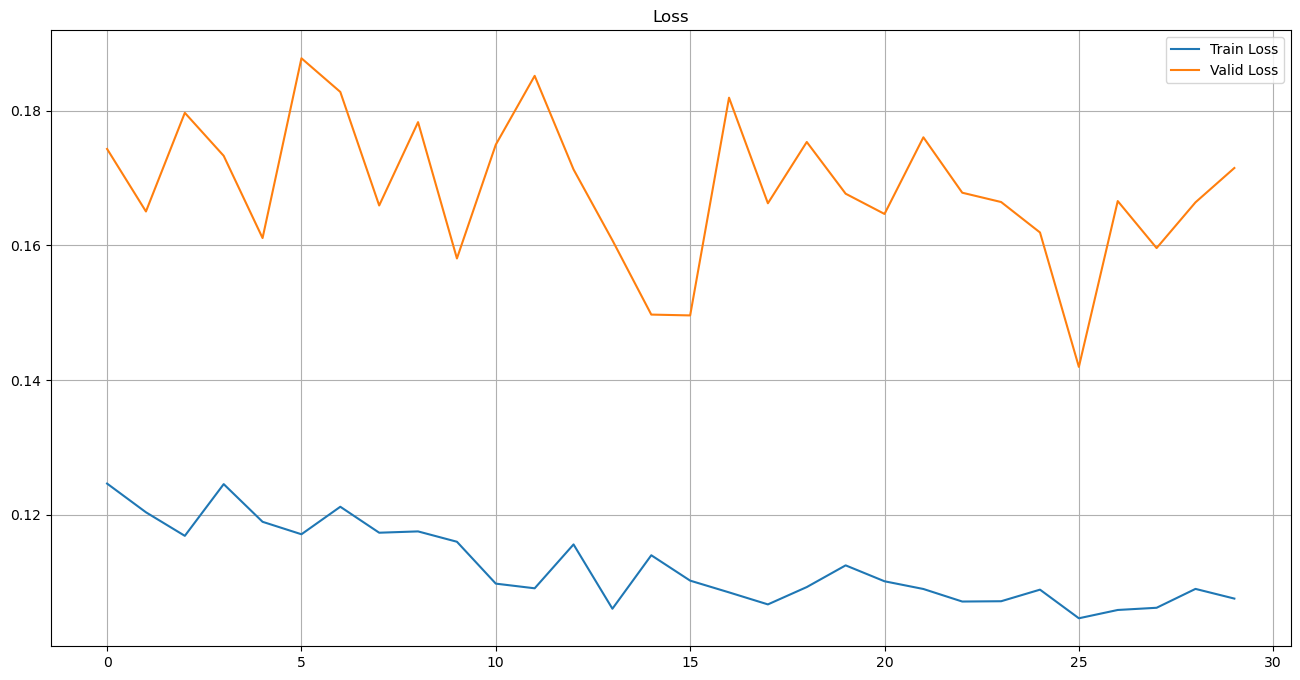

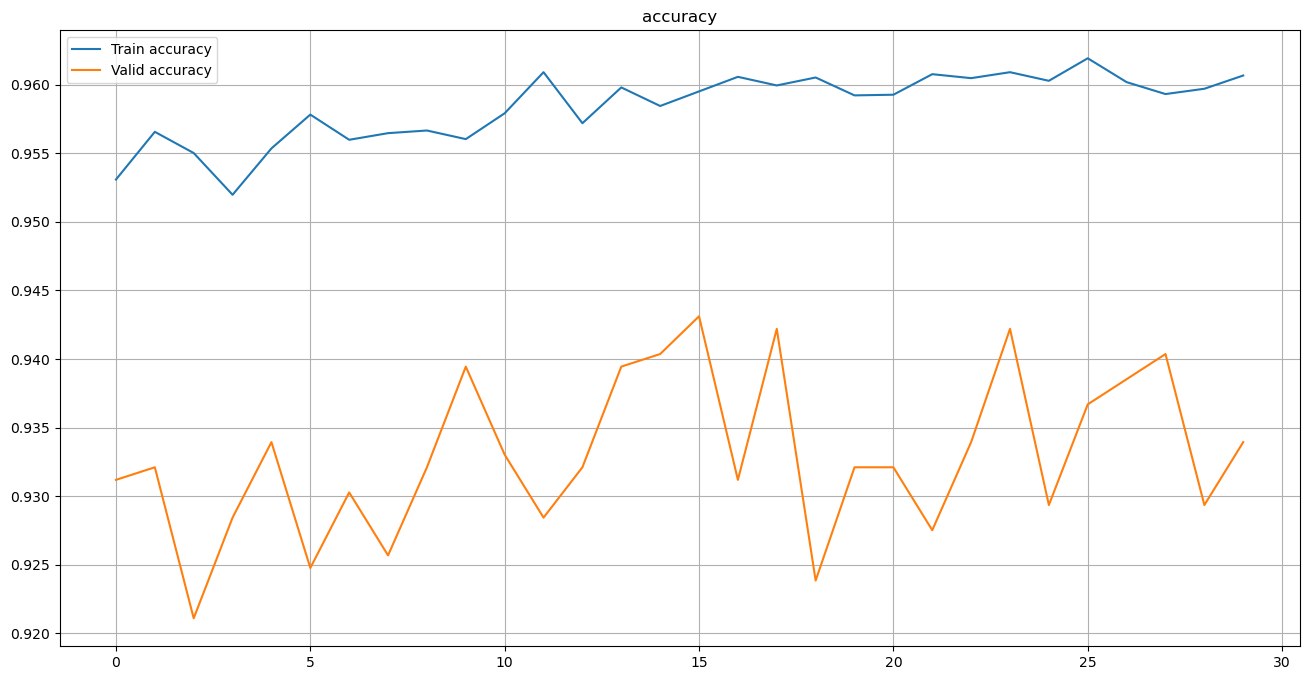

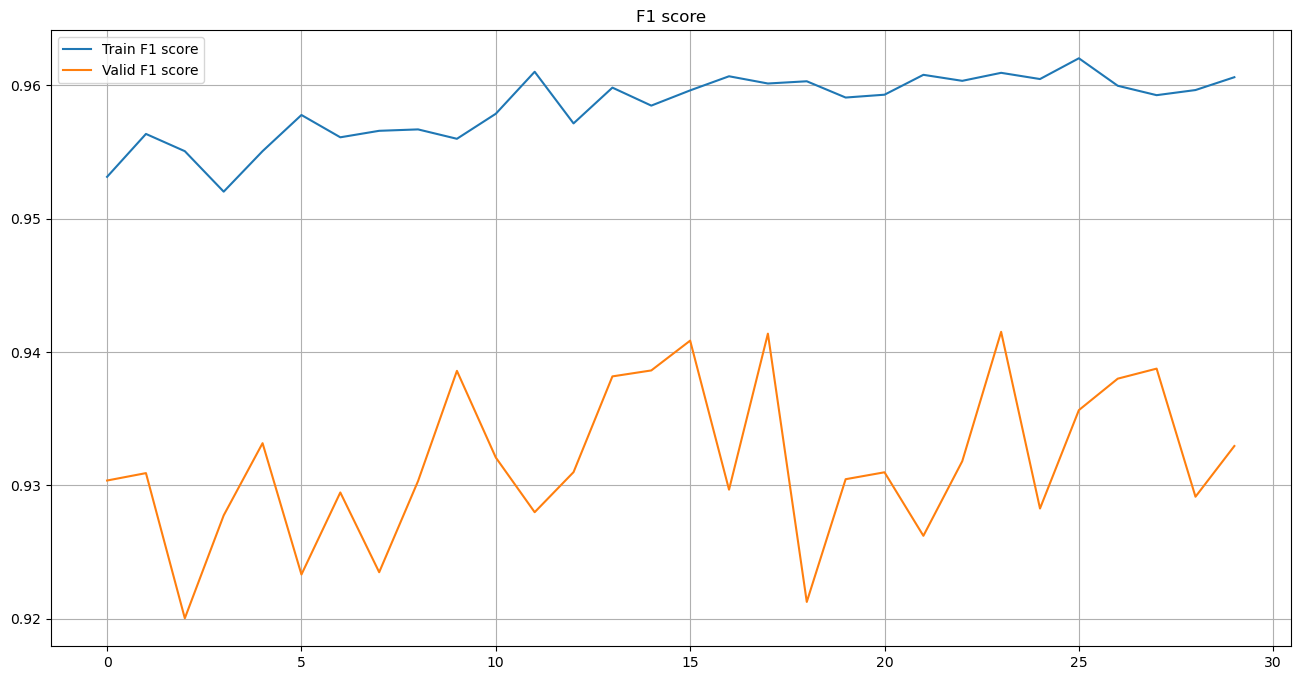

In [127]:
plot_stats(
    **history,
    title=f"Model {config.model_name}"
)

Interactive training tensorboards are available on wandb:

In [120]:
print(wandb_run.url)

'https://wandb.ai/remainedmind/binary-classification-project/runs/vlppfp1s'

# Result evaluation

https://wandb.ai/remainedmind/binary-classification-project/runs/vlppfp1s